In [0]:
# if tensorflow 2.0 beta with gpu is not install install it
v = ! pip list | grep tensorflow-gpu
if len(v) == 0:
  ! pip install tensorflow-gpu==2.0.0-beta0
elif v[0].split()[-1] != '2.0.0b0':
  ! pip install tensorflow-gpu==2.0.0-beta0
else:
  print('You already installed tensorflow 2.0 beta')

In [0]:
# install piexif to fix images
xf = ! pip list | grep piexif
if len(xf) == 0:
  ! pip install piexif
else:
  print('piexif library already installed')

# Prefix
In this notebook, it is a continuation of the Dog_vs_Cat_v1 notebook. We are going to improve on the preprocessing method of the dataset to achieve a better result on the validation accuracy and improve on the overfitting problem.

In [0]:
# import all dependencies
import os
import random
import zipfile
import piexif
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Input
from tensorflow.keras.models import Model
from shutil import copyfile, rmtree
from PIL import Image

# Step - 1: Loading the Data
We will be downloading and extracting the cats vs dogs dataset from the kaggle challenge. This is a dataset that contains 12,501 cats images and 12,501 dogs images. 

In [0]:
# download and extract the Cats-v-Dogs in the /tmp directory
if os.path.exists('/tmp/cats-and-dogs.zip'):
  print('cats-and-dogs.zip already downloaded and extracted to the /tmp directory')
  fix = False
else:
  ! wget --no-check-certificate \
    "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip" \
    -O "/tmp/cats-and-dogs.zip"
  
  # extracting the zip with zipfile
  local_zip = '/tmp/cats-and-dogs.zip'
  zip_ref = zipfile.ZipFile(local_zip, 'r')
  zip_ref.extractall('/tmp')
  zip_ref.close()
  fix = True

In [5]:
cats = '/tmp/PetImages/Cat/'
dogs = '/tmp/PetImages/Dog/'

# verify the extraction is complete
# expected to have 12501 images in each of the directory
print('Number of images in Cat directory:', len(os.listdir('/tmp/PetImages/Cat/')))
print('Number of images in Dog directory:', len(os.listdir('/tmp/PetImages/Dog/')))

Number of images in Cat directory: 12501
Number of images in Dog directory: 12501


### Fixing file corruption or error
Before splitting the dataset we will be fixing some error with in the image's data type and format. 

Note: If you don't fix this error, the model still would train normally, but the images with the error would be skipped. 

In [0]:
# method for removing the exif data from image
def remove_exif(files):
  for f in os.listdir(files):
    if f.lower().endswith('.jpg'):
      try:
          piexif.remove(files+f)
      except:
        if os.path.getsize(files+f) > 0:
          im = Image.open(files+f)
          if im.mode != 'RGB':
            im = im.convert('RGB')
          im.save(files+f, 'JPEG')
          piexif.remove(files+f)
        else:
          print('ignored', f)
        pass
    else:
      print('not jpg', f)

In [7]:
# use this to fix the EXIF error that is going to occur during training
if fix:
  print('This migth going to take a while')
  print('Going to fix the Cat directory')
  remove_exif(cats)
  print('now time to fix the Dog directory')
  remove_exif(dogs)
  fix = False
else:
  print('Images already fixed')

This is going to take a while
Going to fix the Cat directory
ignored 666.jpg
not jpg Thumbs.db
now time to fix the Dog directory
not jpg Thumbs.db
ignored 11702.jpg


### Split the Dataset into Training and Testing
We will be creating the proper directories to store the splitted data in. 

In [0]:
# helper functions for creating tree directory to split the dataset into 
# training and testing
def directory_tree(main, sub, ssub):
  sub_dic = {}
  # checking if the sub directory and ssub directory is a list
  assert isinstance(sub, list), '{} must be a list of directory names'.format(sub)
  assert isinstance(ssub, list), '{} must be a list of directory names'.format(ssub)
  # creating a python dictionary containing th names of the directory tree
  for s in sub:
    sub_dic[s] = ssub
  return {main: sub_dic}

def make_directory(path):
  if not os.path.exists(path):
    os.mkdir(path)
    print(path, 'successfully created!')
  else:
    print(path, "directory already exists!")

# checking to if the directory exists if not create the directory
def create_directory(dictionary, root_dir='/tmp/'):
  for main_dir in dictionary.keys():
    main_path = root_dir+main_dir
    make_directory(main_path)
    for sub_dir in dictionary[main_dir].keys():
      sub_path = main_path+sub_dir
      make_directory(sub_path)
      for ssub_dir in dictionary[main_dir][sub_dir]:
        ssub_path = sub_path+ssub_dir
        make_directory(ssub_path)


# splitting the data into the training and testing set
# then copying it to the proper directory
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
  source = []
  # list all image in the SOURCE then check if the image size 
  # greater than 0 if is append to source list
  # else print the image file will be ignored
  for image in os.listdir(SOURCE):
    if os.path.getsize(SOURCE+image) > 0:
      source.append(image)
    else:
      print(image, "has zero file size, will be ignored")
  
  # find the place to split the list
  split = int(len(source)*SPLIT_SIZE)
  # randomize the list
  random_list = random.sample(source, len(source))
  
  # copy the images to their proper destination
  for i, image in enumerate(random_list):
    file_path = SOURCE+image
    if i < split:
      copyfile(file_path, TRAINING+image)
    else:
      copyfile(file_path, TESTING+image)    

In [9]:
# creating the directory tree
main = 'cats-v-dogs/'
sub=['training/', 'testing/']
ssub = ['cats/', 'dogs/']

# first check if the directory exists in the /tmp directory
# if it does remove it for data consistence
if os.path.exists('/tmp/'+main):
  rmtree('/tmp/'+main')

# now creating the necessary directory 
# and copying the image to the proper directory
tree = directory_tree(main, sub, ssub)
create_directory(tree)

/tmp/cats-v-dogs/ successfully created!
/tmp/cats-v-dogs/training/ successfully created!
/tmp/cats-v-dogs/training/cats/ successfully created!
/tmp/cats-v-dogs/training/dogs/ successfully created!
/tmp/cats-v-dogs/testing/ successfully created!
/tmp/cats-v-dogs/testing/cats/ successfully created!
/tmp/cats-v-dogs/testing/dogs/ successfully created!


In [10]:
# now copying the image to the proper folders
CAT_SOURCE_DIR = "/tmp/PetImages/Cat/"
TRAINING_CATS_DIR = "/tmp/cats-v-dogs/training/cats/"
TESTING_CATS_DIR = "/tmp/cats-v-dogs/testing/cats/"
DOG_SOURCE_DIR = "/tmp/PetImages/Dog/"
TRAINING_DOGS_DIR = "/tmp/cats-v-dogs/training/dogs/"
TESTING_DOGS_DIR = "/tmp/cats-v-dogs/testing/dogs/"

split_size = .9
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, TESTING_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, TESTING_DOGS_DIR, split_size)

666.jpg has zero file size, will be ignored
11702.jpg has zero file size, will be ignored


In [11]:
# checking to see if we copy the image correctly
# Expected outpu: 11250 for training 1250 for testing
print(len(os.listdir('/tmp/cats-v-dogs/training/cats/')))
print(len(os.listdir('/tmp/cats-v-dogs/training/dogs/')))
print(len(os.listdir('/tmp/cats-v-dogs/testing/cats/')))
print(len(os.listdir('/tmp/cats-v-dogs/testing/dogs/')))

11250
11250
1250
1250


# Step - 2: Building the Model


In [0]:
# creating the model
_input = Input((150,150,3))
x = Conv2D(16, (3,3), activation='relu')(_input)
x = MaxPooling2D(2,2)(x)
x = Conv2D(32, (3,3), activation='relu')(x)
x = MaxPooling2D(2,2)(x)
x = Conv2D(64, (3,3), activation='relu')(x)
x = MaxPooling2D(2,2)(x)
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(_input, output)

model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['acc'])

In [13]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 64)        0     

# Step - 3: Preprocessing the Data 
This part of the notebook is a little different from the previous version. We will be using the ImageDataGenerator's augmentation argments to create more samples of image to train the model with in order to minimize overfitting without modifing the orginal file. Those augmentation include `rescale`, `rotation_range`, `width_shift_range`, `height_shift_range`, `shear_range`, `zoom_range`, `horizontal_flip`, and `fill_mode`.

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
# generating the datasets with mulitply augmentations
datagen = ImageDataGenerator(rescale=1./255.,
                             rotation_range=40,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             shear_range=0.2,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             fill_mode='nearest')

TRAINING_DIR = '/tmp/cats-v-dogs/training'
train_generator = datagen.flow_from_directory(TRAINING_DIR,
                                              target_size=(150,150),
                                              class_mode='binary',
                                              batch_size=100)

VALIDATION_DIR = '/tmp/cats-v-dogs/testing'
validation_generator = datagen.flow_from_directory(VALIDATION_DIR,
                                                   target_size=(150,150),
                                                   class_mode='binary',
                                                   batch_size=100)

Found 22498 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


# Step - 4: Training
Training the model with 15 epochs.

In [15]:
history = model.fit_generator(train_generator,
                              epochs=15, 
                              verbose=1,
                              validation_data=validation_generator)

Epoch 1/15


W0612 01:51:06.124577 140061615507328 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


225/225 [==============================] - 184s 818ms/step - loss: 0.6933 - acc: 0.5717 - val_loss: 0.6214 - val_acc: 0.6488
Epoch 2/15
225/225 [==============================] - 170s 757ms/step - loss: 0.6131 - acc: 0.6613 - val_loss: 0.5837 - val_acc: 0.6832
Epoch 3/15
225/225 [==============================] - 171s 758ms/step - loss: 0.5777 - acc: 0.6932 - val_loss: 0.5457 - val_acc: 0.7232
Epoch 4/15
225/225 [==============================] - 172s 764ms/step - loss: 0.5469 - acc: 0.7211 - val_loss: 0.5218 - val_acc: 0.7388
Epoch 5/15
225/225 [==============================] - 171s 762ms/step - loss: 0.5199 - acc: 0.7414 - val_loss: 0.5163 - val_acc: 0.7440
Epoch 6/15
225/225 [==============================] - 170s 754ms/step - loss: 0.5091 - acc: 0.7474 - val_loss: 0.4946 - val_acc: 0.7612
Epoch 7/15
225/225 [==============================] - 171s 758ms/step - loss: 0.5004 - acc: 0.7536 - val_loss: 0.5047 - val_acc: 0.7536
Epoch 8/15
225/225 [==============================] - 169s 

### Plotting the training and testing history

Text(0.5, 1.0, 'Training and validation loss')

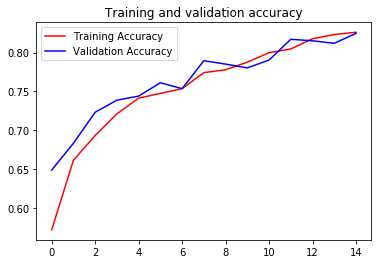

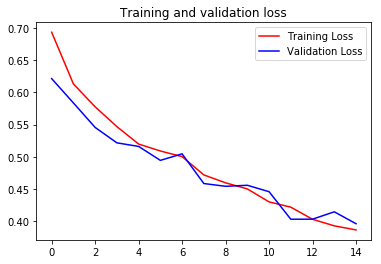

In [18]:
# PLOT LOSS AND ACCURACY
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', label="Training Accuracy")
plt.plot(epochs, val_acc, 'b', label="Validation Accuracy")
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")
plt.legend()
plt.title('Training and validation loss')

# Desired output. Charts with training and validation metrics. No crash :)

As you can see the augmentation has a great effect on training of the model. The accuracies and losses in both training and validation are relativity close, unlike the previous version where the validation does worse than training. 

### Test your own image

In [19]:
# Here's a codeblock just for fun. You should be able to upload an image here 
# and have it classified without crashing

import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
  path = '/content/' + fn
  img = image.load_img(path, target_size=(150, 150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
  if classes[0]>0.5:
    print(fn + " is a dog")
  else:
    print(fn + " is a cat")

Using TensorFlow backend.


Saving cat-ear.png to cat-ear.png
[0.]
cat-ear.png is a cat
